In [6]:
%reset
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from info.core.ccm import ccm, extended_ccm
from info.plot import plot_ccm
from info.utils.others import corrcoefs, parse_SFP, aggregate, butter_filter
from info.utils.sst import conductSST_withlag

## Read the SFP data, filtered the data and conduct CCM and MI on it

In [4]:
# Read the data
filepath = '../data/SFP2_AllData.mat'
times, data, header, doy = parse_SFP(filepath)
precip, rh, temp = data[:, 1], data[:, 2], data[:, 3]
solar, wind      = data[:, 4], data[:, 5]

In [5]:
fs = 1./60.          # the sample rate
fc = 1./(60.*60.*6.) # the cutoff frequency (6hr)
N  = 5               # the order of the butterworth filter
precipf = butter_filter(precip, N, fs, fc, btype='high')
rhf     = butter_filter(rh, N, fs, fc, btype='high')
tempf   = butter_filter(temp, N, fs, fc, btype='high')
solarf  = butter_filter(solar, N, fs, fc, btype='high')
windf   = butter_filter(wind, N, fs, fc, btype='high')

In [6]:
# Define the coefficients for CCM
tau_set = range(1, 21, 2)
E_set = range(2, 22, 2)
tsize = len(tau_set)
Esize = len(E_set)
# Settings for plot
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

### 1. A simple test on temperature and relative humidity

In [7]:
lagmax, L = 300, 1000
# Analysis on the original data
lagset, rhoxmpy, rhoympx = extended_ccm(temp[:L], rh[:L], temp[:L], rh[:L], 2, lagmax, 1)
lagset, rhoympz, rhozmpy = extended_ccm(rh[:L], temp[:L], rh[:L], temp[:L], 2, lagmax, 1)
lagset, mirxy, mixy = conductSST_withlag(temp[:L], rh[:L], lagmax, returnTrue=True, approach='kde_c')
rhoxy = corrcoefs(temp[:L], rh[:L], lagset)
# Analysis on the filtered data
lagset, rhoxmpyf, rhoympxf = extended_ccm(tempf[:L], rhf[:L], tempf[:L], rhf[:L], 2, lagmax, 1)
lagset, rhoympzf, rhozmpyf = extended_ccm(rhf[:L], tempf[:L], rhf[:L], tempf[:L], 2, lagmax, 1)
lagset, mirxyf, mixyf = conductSST_withlag(tempf[:L], rhf[:L], lagmax, returnTrue=True, approach='kde_c')
rhoxyf = corrcoefs(tempf[:L], rhf[:L], lagset)

KeyboardInterrupt: 

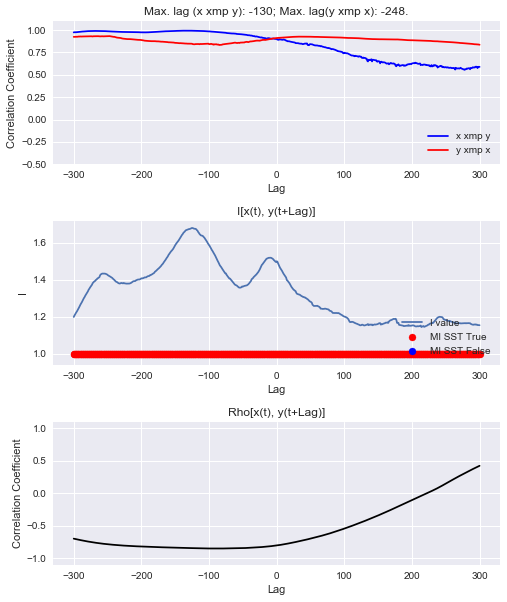

In [32]:
# Plots
plot_ccm.plot_extended_ccm_xy_withmi(lagset, rhoxmpy, rhoympx, rhoxy, mirxy, mixy)
plot_ccm.plot_extended_ccm_xy_withmi(lagset, rhoxmpyf, rhoympxf, rhoxyf, mirxyf, mixyf)
plt.show()
# rhoxy

### 2.1. Tests on the accumulated and averaged data -- hourly data

In [12]:
# Define
lagmax, L = 30, 1000
# Hourly data
interval = 60
prep_hr  = aggregate(precip, interval, method='accumulate')
rh_hr    = aggregate(rh, interval, method='average')
temp_hr  = aggregate(temp, interval, method='average')
solar_hr = aggregate(solar, interval, method='accumulate')
wind_hr  = aggregate(wind, interval, method='average')

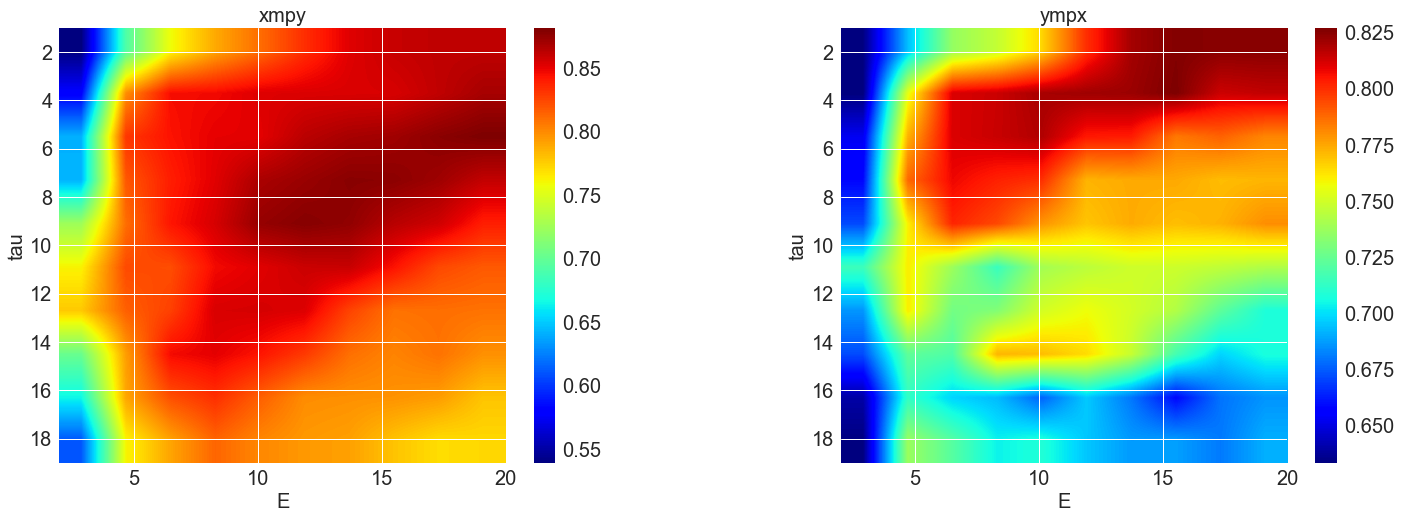

In [31]:
x, y = temp_hr[:L], rh_hr[:L]
x_f, y_f = temp_hr[L:2*L], rh_hr[L:2*L]
xmpy, ympx = np.zeros([tsize, Esize]), np.zeros([tsize, Esize])
for i in range(tsize):
    tau = tau_set[i]
    for j in range(Esize):
        E = E_set[j]
        _, rho1 = ccm(x, y, x_f, y_f, E, tau)
        _, rho2 = ccm(y, x, y_f, x_f, E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2
# Plot
extent = [E_set[0], E_set[-1], tau_set[-1], tau_set[0]]
xv, yv = np.meshgrid(tau_set, E_set, indexing='ij')
plot_ccm.plot_ccm_xy(xmpy, ympx, extent, 'E', 'tau')
plt.show()

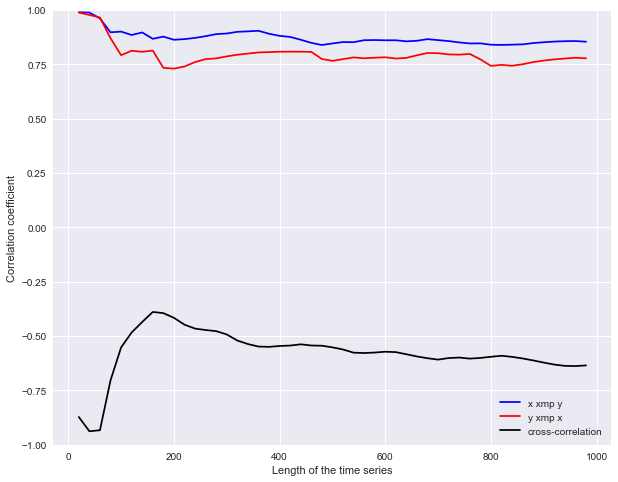

In [92]:
# Compute rho for different lengths of the time series
L = 1000
x, y = temp_hr[:L], rh_hr[:L]
x_f, y_f = temp_hr[:L], rh_hr[:L]
xmpy, ympx = [], []
rhoset = []
L_set = range(20, L, 20)
E, tau = 4, 2
for l in L_set:
    _, rho1 = ccm(x[:l], y[:l], x_f[:l], y_f[:l], E, tau)
    _, rho2 = ccm(y[:l], x[:l], y_f[:l], x_f[:l], E, tau)
    rhoset.append(np.corrcoef(x[:l], y[:l])[0,1])
    xmpy.append(rho1)
    ympx.append(rho2)

# Plot
plot_ccm.plot_ccm(L_set, xmpy, ympx, rhoset)
plt.show()

In [50]:
# Conduct CCM on precip and rh
lagset, rhoxmpy, rhoympx = extended_ccm(temp_hr[:L], rh_hr[:L], temp_hr[:L], rh_hr[:L], 2, lagmax, 1)
lagset, rhoympz, rhozmpy = extended_ccm(rh_hr[:L], temp_hr[:L], rh_hr[:L], temp_hr[:L], 2, lagmax, 1)
lagset, mirxy, mixy = conductSST_withlag(temp_hr[:L], rh_hr[:L], lagmax, returnTrue=True, approach='kde_c')
rhoxy = corrcoefs(temp_hr[:L], rh_hr[:L], lagset)

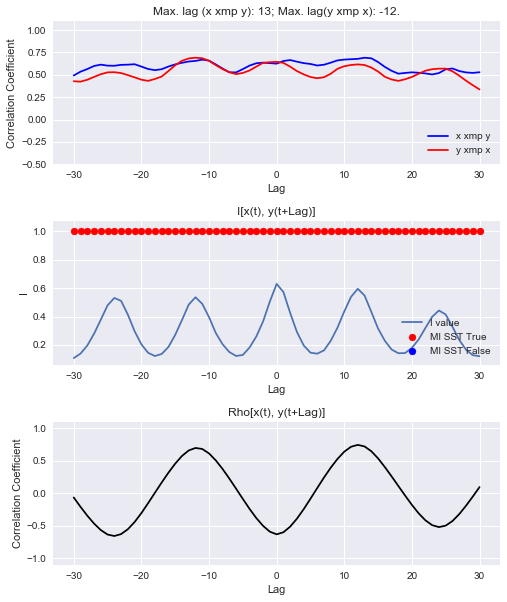

In [51]:
# Plots
plot_ccm.plot_extended_ccm_xy_withmi(lagset, rhoxmpy, rhoympx, rhoxy, mirxy, mixy)
plt.show()

### 2.2. Tests on the accumulated and averaged data -- daily data

In [32]:
# Define
lagmax, L = 30, 1000
# Hourly data
interval = 60*24
prep_d  = aggregate(precip, interval, method='accumulate')
rh_d    = aggregate(rh, interval, method='average')
temp_d  = aggregate(temp, interval, method='average')
solar_d = aggregate(solar, interval, method='accumulate')
wind_d  = aggregate(wind, interval, method='average')

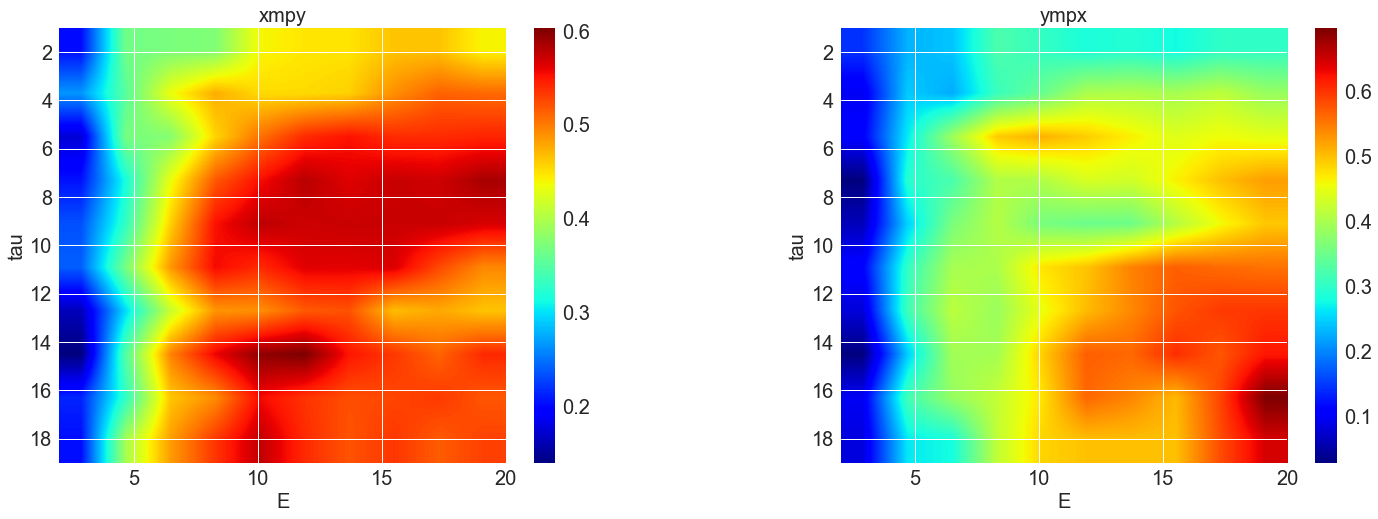

In [33]:
x, y = temp_d, rh_d
x_f, y_f = temp_d, rh_d
xmpy, ympx = np.zeros([tsize, Esize]), np.zeros([tsize, Esize])
for i in range(tsize):
    tau = tau_set[i]
    for j in range(Esize):
        E = E_set[j]
        _, rho1 = ccm(x, y, x_f, y_f, E, tau)
        _, rho2 = ccm(y, x, y_f, x_f, E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2
# Plot
extent = [E_set[0], E_set[-1], tau_set[-1], tau_set[0]]
xv, yv = np.meshgrid(tau_set, E_set, indexing='ij')
plot_ccm.plot_ccm_xy(xmpy, ympx, extent, 'E', 'tau')
plt.show()

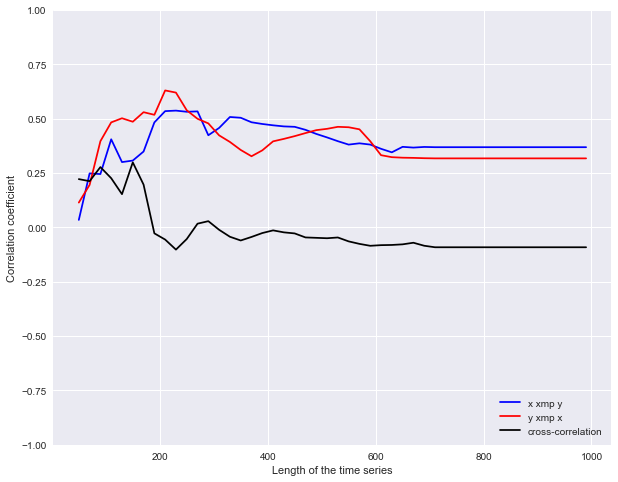

In [80]:
# Compute rho for different lengths of the time series
xmpy, ympx = [], []
rhoset = []
L_set = range(50, 1000, 20)
E, tau = 5, 6
for l in L_set:
    _, rho1 = ccm(x[:l], y[:l], x_f[:l], y_f[:l], E, tau)
    _, rho2 = ccm(y[:l], x[:l], y_f[:l], x_f[:l], E, tau)
    rhoset.append(np.corrcoef(x[:l], y[:l])[0,1])
    xmpy.append(rho1)
    ympx.append(rho2)

# Plot
plot_ccm.plot_ccm(L_set, xmpy, ympx, rhoset)
plt.show()

In [93]:
# Conduct CCM on precip and rh
E, tau = 5, 6
lagset, rhoxmpy, rhoympx = extended_ccm(temp_d, rh_d, temp_d, rh_d, E, lagmax, tau)
lagset, rhoympz, rhozmpy = extended_ccm(rh_d, temp_d, rh_d, temp_d, E, lagmax, tau)
lagset, mirxy, mixy = conductSST_withlag(temp_d, rh_d, lagmax, returnTrue=True, approach='kde_c')
rhoxy = corrcoefs(temp_d, rh_d, lagset)

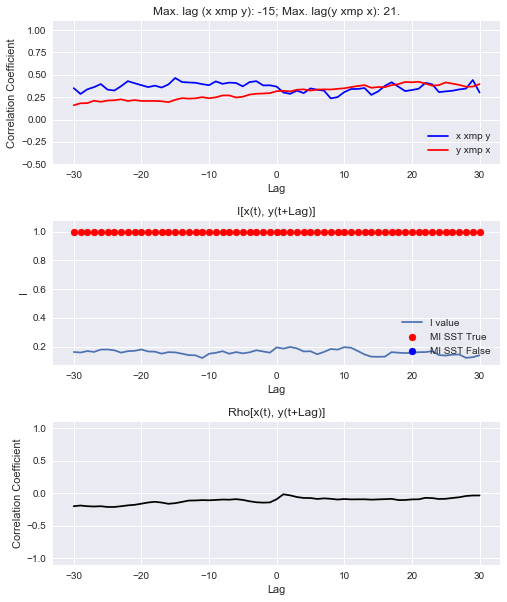

In [94]:
# Plots
plot_ccm.plot_extended_ccm_xy_withmi(lagset, rhoxmpy, rhoympx, rhoxy, mirxy, mixy)
plt.show()